# BERT Fine-Tuning Tutorial with PyTorch

By Chris McCormick and Nick Ryan

*Revised on 3/20/20 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*




In this tutorial I'll show you how to use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.

This post is presented in two forms--as a blog post [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) and as a Colab Notebook [here](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX). 

The content is identical in both, but: 
* The blog post includes a comments section for discussion. 
* The Colab Notebook will allow you to run the code and inspect it as you read through.

I've also published a video walkthrough of this post on my YouTube channel! [Part 1](https://youtu.be/x66kkDnbzi4) and [Part 2](https://youtu.be/Hnvb9b7a_Ps).



# Contents

See "Table of contents" in the sidebar to the left.

# Introduction


## History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.



## What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 



## Advantages of Fine-Tuning



In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

1. **Quicker Development**

    * First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.



### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

# 1. Setup

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [1]:
!nvidia-smi

Sat May 16 18:03:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [0]:
import torch
device = torch.device("cpu")

In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


## 1.2. Installing the Hugging Face Library



Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.


In [5]:
!pip install transformers

The code in this notebook is actually a simplified version of the [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) example script from huggingface.

`run_glue.py` is a helpful utility which allows you to pick which GLUE benchmark task you want to run on, and which pre-trained model you want to use (you can see the list of possible models [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). It also supports using either the CPU, a single GPU, or multiple GPUs. It even supports using 16-bit precision if you want further speed up.

Unfortunately, all of this configurability comes at the cost of *readability*. In this Notebook, we've simplified the code greatly and added plenty of comments to make it clear what's going on. 

# 2. Loading MultiFC Dataset


## 2.1. Download & Extract

We'll use the `wget` package to download the dataset to the Colab instance's file system. 

In [6]:
!pip install wget

In [7]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://competitions.codalab.org/my/datasets/download/4db8bf21-def7-4a86-99f5-7b23d5691bb3'

# Download the file (if we haven't already)
if not os.path.exists('multi-fc/'):
    !mkdir multi-fc
    wget.download(url, 'multi-fc/multi-fc.zip')
    !unzip multi-fc/multi-fc.zip -d multi-fc/

## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [8]:
import pandas as pd
import csv

# Load the dataset into a pandas dataframe.
train_df = pd.read_csv("multi-fc/train.tsv", delimiter='\t', header=None, quoting=csv.QUOTE_NONE, \
                 names= ['claimID', 'claim', 'label', 'claimURL', 'reason', 'categories', 'speaker', \
                  'checker', 'tags', 'articleTitle', 'publishDate', 'claimDate', 'entities'])

dev_df = pd.read_csv("multi-fc/dev.tsv", delimiter='\t', header=None, quoting=csv.QUOTE_NONE, \
                 names= ['claimID', 'claim', 'label', 'claimURL', 'reason', 'categories', 'speaker', \
                  'checker', 'tags', 'articleTitle', 'publishDate', 'claimDate', 'entities'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Report the number of sentences.
print('Number of dev sentences: {:,}\n'.format(dev_df.shape[0]))

# Display 2 random rows from the data.
train_df.head()

Number of training sentences: 27,940

Number of dev sentences: 3,493



,claimID,claim,label,claimURL,reason,categories,speaker,checker,tags,articleTitle,publishDate,claimDate,entities
0,pomt-03627,"""Six out of 10 of the highest unemployment rat...",half-true,/ohio/statements/2013/may/06/chris-redfern/ohi...,When a couple of Statehouse Republicans prepar...,None,Chris Redfern,None,None,None,2013-05-06T06:00:00,2013-04-30,['None']
1,pomt-09611,"""No Democratic campaign for (Fla.) governor ha...",true,/florida/statements/2010/jan/15/alex-sink/flor...,Florida's leading Republican candidate for gov...,None,Alex Sink,None,None,None,2010-01-15T13:59:00,2010-01-06,['None']
2,tron-00214,Forward an email for Jasmine,fiction!,https://www.truthorfiction.com/jasmine/,None,9-11-attack,None,None,None,Forward an email for Jasmine,"Mar 17, 2015",None,['None']
3,snes-04484,Pope Francis endorsed Donald Trump for president.,false,https://www.snopes.com/fact-check/pope-francis...,None,Junk News,None,Dan Evon,None,"Pope Francis Shocks World, Endorses Donald Tru...",10 July 2016,None,['None']
4,pomt-06704,Says Ron Paul insisted FEMA should be shut down.,true,/texas/statements/2011/sep/03/maureen-dowd/mau...,Commenting on the federal response to Hurrican...,None,Maureen Dowd,None,None,None,2011-09-03T06:00:00,2011-08-30,['None']


In [0]:
# train_df = train_df.append(dev_df, ignore_index = True)

In [0]:
def generate_domain_df(df):
    getDomain = lambda x: x[:4]
    return df['claimID'].apply(getDomain).reset_index().rename(columns={"claimID": "domain"})

In [0]:
def sample_df(df, sample_frac=0.1):
    getDomain = lambda x: x[:4]
    df['domain'] = df['claimID'].apply(getDomain)
    df = df.groupby('domain').apply(lambda x: x.sample(frac = sample_frac))
    df.reset_index(drop=True,inplace=True)
    df.drop(columns=['domain'],inplace=True)
    return df

In [0]:
def drop_malformed(df):
    return df.dropna(subset=['claim']).reset_index()

In [13]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_df['label'])

LabelEncoder()

In [0]:
# train_df = sample_df(train_df)

In [0]:
#gives original train and dev DFs with just the bad claims dropped
train_df = drop_malformed(train_df)
dev_df = drop_malformed(dev_df)

In [0]:
##gives df of domain for every claim
train_domains = generate_domain_df(train_df)
dev_domains = generate_domain_df(dev_df)

##maps domain name to id from 0 to domains - 1 
domain_to_domain_id = {k: v for v, k in enumerate(train_domains.domain.unique())}

## replaces domain name column with domain id
train_domains = train_domains.replace({'domain': domain_to_domain_id})
dev_domains = dev_domains.replace({'domain': domain_to_domain_id})

In [0]:
## creates dataframe with claim, index, domain id
train_claims = pd.concat([train_df[['claim']], train_domains], axis=1)
dev_claims = pd.concat([dev_df[['claim']], dev_domains], axis=1)


In [0]:
##gives dfs with label, index, domain_id
train_labels = pd.concat([train_df['label'], train_domains], axis=1)
dev_labels = pd.concat([dev_df['label'], dev_domains], axis=1)

##creates dictionary mapping domain_id to all possible labels within domain
train_labels_map_to_domain = train_labels.groupby('domain')['label'].apply(set).apply(list).to_dict()
dev_labels_map_to_domain = dev_labels.groupby('domain')['label'].apply(set).apply(list).to_dict()

##maps possible labels within to domain to 0 to num_labels-1
for domain in train_labels_map_to_domain:
    train_labels_map_to_domain[domain] = {k: v for v, k in enumerate(train_labels_map_to_domain[domain])} 



## creates list of size len(train) and len(dev) where each label is mapped to its' value within its' domain as per previous code
original_train_labels = train_labels
train_labels = []
original_dev_labels = dev_labels
dev_labels = []
for index, row in original_train_labels.iterrows():
    train_labels.append(train_labels_map_to_domain[row.domain][row.label])
for index, row in original_dev_labels.iterrows():
    dev_labels.append(train_labels_map_to_domain[row.domain][row.label])

In [0]:
## creates dfs with label_id, index, domain per row (claim) and dictionary mapping
train_lab_dom = pd.concat([pd.DataFrame(train_labels, columns=['label_id']), train_domains], axis=1)
train_domain_label_map = train_lab_dom.groupby('domain')['label_id'].apply(set).to_dict()

dev_lab_dom = pd.concat([pd.DataFrame(dev_labels, columns=['label_id']), dev_domains], axis=1)
dev_domain_label_map = dev_lab_dom.groupby('domain')['label_id'].apply(set).to_dict()

domain_label_map = train_domain_label_map

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [20]:
from transformers import RobertaTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



### Special Tokens



**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

I am not certain yet why the token is still required when we have only single-sentence input, but it is!


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!



### Sentence Length & Attention Mask



The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

**AREN'S EDITS:** an additional for loop will be added, and encode will change to encode_plus to add second param for snippet

In [21]:
max_len = 0

# For every sentence...
for index, row in train_claims.iterrows():
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(row.claim, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1310 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1312


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [0]:
from torch.utils.data import TensorDataset
from collections import defaultdict

#ADD THIS = None#
def encode_claims(df_claims, en_labels = None, input_seq_length=200):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = defaultdict(list)
    attention_masks = defaultdict(list)
    labels = defaultdict(list)

    datasets = {}
    domains_to_tensors = {}

    # For every sentence...
    for index, row in df_claims.iterrows():

        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            row.claim,                            # Sentence to encode.
                            add_special_tokens = True,       # Add '[CLS]' and '[SEP]'
                            max_length = input_seq_length, # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,    # Construct attn. masks.
                            return_tensors = 'pt',           # Return pytorch tensors.
                    )

        # Add the encoded sentence to the list.    
        input_ids[row.domain].append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks[row.domain].append(encoded_dict['attention_mask'])


        if en_labels is not None:
          labels[row.domain].append(en_labels[index])


    for domain in domain_label_map:
        # Convert the lists into tensors.
        input_temp = torch.cat(input_ids[domain], dim=0)
        attention_masks_temp = torch.cat(attention_masks[domain], dim=0)

        if en_labels is not None:
          labels_temp = torch.tensor(labels[domain])
        
          datasets[domain] = TensorDataset(input_temp, attention_masks_temp, labels_temp)
        else:
          datasets[domain] = TensorDataset(input_temp, attention_masks_temp)



    return datasets

In [0]:
train_datasets = encode_claims(train_claims, train_labels)
dev_datasets = encode_claims(dev_claims, dev_labels)

## 3.4. Training & Validation Split


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# Effective batch size is batch_size * accumulation_steps
batch_size = 16

train_dataloaders = {}
validation_dataloaders = {}

for idx, domain in enumerate(domain_label_map):

    # Create the DataLoaders for our training and validation sets.
    # We'll take training samples in random order. 
    train_dataloaders[domain] = DataLoader(
                train_datasets[domain],  # The training samples.
                sampler = RandomSampler(train_datasets[domain]), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    # For validation the order doesn't matter, so we'll just read them sequentially.
    validation_dataloaders[domain] = DataLoader(
                dev_datasets[domain], # The validation samples.
                sampler = SequentialSampler( dev_datasets[domain]), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [0]:
from torch import nn

class MultiLinear(nn.Module):
    def __init__(self, hidden_size, domain_label_map):
        super(MultiLinear, self).__init__()
        self.linear_models = {}
        for domain in domain_label_map:
            self.linear_models[domain] = nn.Linear(hidden_size, len(domain_label_map[domain])).to(device)

    def forward(self, domain, input):
        return self.linear_models[domain].forward(input)

In [0]:
from transformers import RobertaForSequenceClassification, RobertaModel
from torch.nn import CrossEntropyLoss

class RobertaForSequenceClassificationMultiDomain(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = MultiLinear(config.hidden_size, domain_label_map)
        self.init_weights()
        
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, \
        inputs_embeds=None, \
        m_labels=None,
        m_domain=None):
        """
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`, defaults to :obj:`None`):
            Labels for computing the sequence classification/regression loss.
            Indices should be in :obj:`[0, ..., config.num_labels - 1]`.
            If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).

    Returns:
        :obj:`tuple(torch.FloatTensor)` comprising various elements depending on the configuration (:class:`~transformers.BertConfig`) and inputs:
        loss (:obj:`torch.FloatTensor` of shape :obj:`(1,)`, `optional`, returned when :obj:`label` is provided):
            Classification (or regression if config.num_labels==1) loss.
        logits (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, config.num_labels)`):
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        hidden_states (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_hidden_states=True``):
            Tuple of :obj:`torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer)
            of shape :obj:`(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        attentions (:obj:`tuple(torch.FloatTensor)`, `optional`, returned when ``config.output_attentions=True``):
            Tuple of :obj:`torch.FloatTensor` (one for each layer) of shape
            :obj:`(batch_size, num_heads, sequence_length, sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.

    Examples::

        from transformers import BertTokenizer, BertForSequenceClassification
        import torch

        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

        input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
        labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        outputs = model(input_ids, labels=labels)

        loss, logits = outputs[:2]

        """

        outputs = self.roberta(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask,
                            inputs_embeds=inputs_embeds)

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(domain, pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        loss_fct = CrossEntropyLoss()
        
         #Allows m_labels as None for testing
        if m_labels is None:
          loss = 0
        else:
          loss = loss_fct(logits.view(-1, len(domain_label_map[m_domain.item()])), m_labels.view(-1))
        outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [0]:
from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassificationMultiDomain.from_pretrained(
    "roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(le.classes_), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda();

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [28]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 199 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

total_steps = 0
for domain in domain_label_map:
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps += len(train_dataloaders[domain]) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
from sklearn.metrics import f1_score

def f1_macro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='macro')

def f1_micro(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='micro')

Helper function for formatting elapsed times as `hh:mm:ss`


In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [34]:
import random
import numpy as np
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    domains = list(domain_label_map.keys())
    random.shuffle(domains)

    dataloaders_iters = {}
    dataloader_batch_tracker = {}
    for domain in train_dataloaders:
        dataloaders_iters[domain] = iter(train_dataloaders[domain])
        dataloader_batch_tracker[domain] = 0
    train_domains_list = domains.copy()
    total_train_loss = 0
    step = 0

    while train_domains_list:
        domain = random.choice(train_domains_list)
        dataloader_batch_tracker[domain] += 1
        try:
            batch = next(dataloaders_iters[domain])
        except StopIteration: 
            train_domains_list.remove(domain)
            continue

        step += 1
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(dataloader_batch_tracker[domain], len(train_dataloaders[domain]), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_domain = torch.tensor([domain]).to(device)

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask, 
                            m_labels=b_labels,
                            m_domain=b_domain)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / step         
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # F1 Scores
    f1_macro_score = 0
    f1_micro_score = 0

    for domain in validation_dataloaders:
        dataloaders_iters[domain] = iter(validation_dataloaders[domain])
        dataloader_batch_tracker[domain] = 0
    step = 0
    validation_domains_list = domains.copy()

    while validation_domains_list:
        step += 1
        domain = random.choice(validation_domains_list)
        
        try:
            batch = next(dataloaders_iters[domain])
        except StopIteration: 
            validation_domains_list.remove(domain)
            continue

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_domain = torch.tensor([domain]).to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                m_labels=b_labels,
                                m_domain=b_domain)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        f1_macro_score += f1_macro(logits, label_ids) 
        f1_micro_score += f1_micro(logits, label_ids) 

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / step
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Report the final f1 macro score for this validation run.
    avg_val_f1_macro = f1_macro_score / step
    print("  F1 Macro: {0:.2f}".format(avg_val_f1_macro))

    # Report the final f1 micro score for this validation run.
    avg_val_f1_micro = f1_micro_score / step
    print("  F1 Micro: {0:.2f}".format(avg_val_f1_micro))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / step

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch     2  of     22.    Elapsed: 0:00:12.
  Batch     7  of    166.    Elapsed: 0:00:25.
  Batch     4  of      4.    Elapsed: 0:00:37.
  Batch    13  of     33.    Elapsed: 0:00:50.
  Batch     7  of     11.    Elapsed: 0:01:02.
  Batch    11  of    323.    Elapsed: 0:01:15.
  Batch    16  of     22.    Elapsed: 0:01:28.
  Batch    17  of    770.    Elapsed: 0:01:41.
  Batch    26  of     69.    Elapsed: 0:01:53.
  Batch    26  of    770.    Elapsed: 0:02:06.
  Batch    33  of    770.    Elapsed: 0:02:19.
  Batch    49  of     69.    Elapsed: 0:02:32.
  Batch    58  of    166.    Elapsed: 0:02:44.
  Batch    59  of    770.    Elapsed: 0:02:57.
  Batch    64  of    148.    Elapsed: 0:03:10.
  Batch    57  of    323.    Elapsed: 0:03:23.
  Batch    90  of    166.    Elapsed: 0:03:36.
  Batch   100  of    770.    Elapsed: 0:03:48.
  Batch   108  of    166.    Elapsed: 0:04:01.
  Batch   108  of    148.    Elapsed: 0:04:14.
  Batch   120  of    148.    Elapsed: 0:04:27.
  Batch   130

All data, separate classifier heads, 128 input length, batch size 16

Running Validation...
  Accuracy: 0.45
  F1 Macro: 0.24
  F1 Micro: 0.45
  Validation Loss: 1.72
  Validation took: 0:01:00

All data, separate classifier heads, 128 input length, batch size 16. random batches. 0.27 F1 Macro. 0.42 F1 macro.

All data, separate classifier heads, 512 input length, batch size 16. random batches. 0.26 F1 Macro. 0.42 F1 macro.

Let's view the summary of the training process.

In [35]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.57,1.34,0.39,0:09:23,0:00:22
2,1.41,1.26,0.42,0:09:24,0:00:22


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


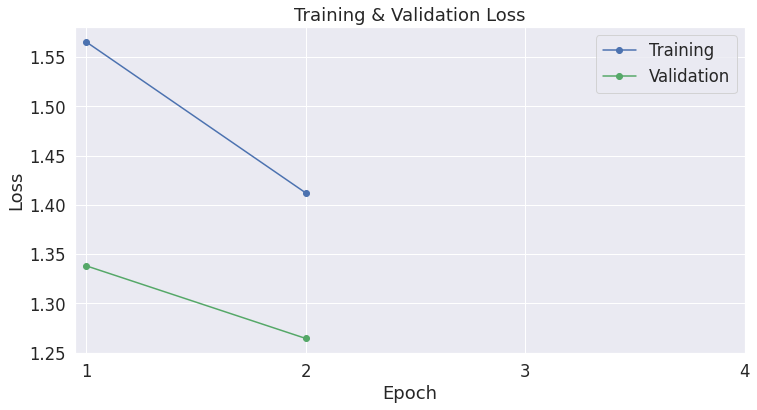

In [36]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [37]:
test_df = pd.read_csv("multi-fc/test.tsv", delimiter='\t', header=None, quoting=csv.QUOTE_NONE, \
                 names= ['claimID', 'claim', 'claimURL', 'reason', 'categories', 'speaker', \
                  'checker', 'tags', 'articleTitle', 'publishDate', 'claimDate', 'entities'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

index_to_add = test_df.index[test_df.isnull()['claim'] == True].tolist()

test_df = drop_malformed(test_df)
print(len(test_df))

##gives df of domain for every claim
test_domains = generate_domain_df(test_df)
## replaces domain name column with domain id
test_domains = test_domains.replace({'domain': domain_to_domain_id})

test_claims = pd.concat([test_df[['claim']], test_domains], axis=1)

test_datasets = encode_claims(test_claims)

#Claim idx domain map used to correctly sort output
test_domain_idx_map = test_domains.groupby('domain')['index'].apply(list).to_dict()

Number of test sentences: 3,491

3490


In [38]:
index_to_add[0]

1039

In [0]:
test_dataloaders = {}

for idx, domain in enumerate(domain_label_map):

    # Create the DataLoaders for our test set.
    # For test the order doesn't matter, so we'll just read them sequentially.
    
    test_dataloaders[domain] = DataLoader(
                test_datasets[domain], # The validation samples.
                sampler = SequentialSampler( test_datasets[domain]), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )

## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [40]:
print("Running Testing...")

t0 = time.time()
predictions = []
pred_domains = []

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
model.eval()

for domain in test_dataloaders:
    dataloaders_iters[domain] = iter(test_dataloaders[domain])
    dataloader_batch_tracker[domain] = 0
step = 0
test_domains_list = domains.copy()

while test_domains_list:
    step += 1
    domain = random.choice(test_domains_list)
        
    try:
        batch = next(dataloaders_iters[domain])
    except StopIteration: 
        test_domains_list.remove(domain)
        continue
    
    pred_domains.append(domain)

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    # b_labels = batch[2].to(device)
    b_domain = torch.tensor([domain]).to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                m_domain=b_domain)
            
        # Accumulate the validation loss.
    logits = outputs[1]
  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
    predictions.append(logits)

print('    DONE.')

Running Testing...
    DONE.


In [41]:
import itertools
y_pred = []
batch_sizes = []
for i in range(len(predictions)):
  
  #Pick the label with the highest value and consider the index = class
  #take note of current domain 
  pred_labels_i = list(np.argmax(predictions[i], axis=1))
  current_domain = train_labels_map_to_domain[pred_domains[i]]

  #take note of batch size 
  batch_sizes.append(len(pred_labels_i))
  for j in pred_labels_i:
    label = list(current_domain.keys())[list(current_domain.values()).index(j)]
    y_pred.append(label)

#Get domain respective to each prediction, domain X batch_size
domain_order = []
for idx, domain in enumerate(pred_domains):
  batch_size = batch_sizes[idx]
  for i in range(batch_size):
    domain_order.append(domain)

#Obtain claim index of each prediction
new_index = []
for domain in domain_order:
  new_index.append(test_domain_idx_map[domain][0])
  test_domain_idx_map[domain].pop(0)

#Sort predictions based on original index 
y_pred = [x for _,x in sorted(zip(new_index,y_pred))]

y_pred.insert(index_to_add[0],'false')
y_pred[0:5]

['false', 'false', 'false', 'mostly true', 'false']

In [42]:
#click on the link and follow instructions
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
with open('/drive/My Drive/test_mult.predict', 'w') as filehandle:
    filehandle.writelines("%s\n" % pred for pred in y_pred)